Import necessary dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# elif torch.backends.mps.is_available():
#     device = torch.device("mps:0")
else:
    device = torch.device("cpu")

Load data

In [4]:
data = pd.read_csv('datasets/IoT_Modbus.csv')

Combine 'date' and 'time' into a single datetime column

In [ ]:
data['date'] = data['date'].str.strip()
data['time'] = data['time'].str.strip()
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%b-%y %H:%M:%S')

Extract time features

In [6]:
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['dayofweek'] = data['datetime'].dt.dayofweek

Time series models need to ensure that the data set is arranged in time order

In [7]:
# Sort the data by datetime
data = data.sort_values(by='datetime')

# Drop the original date, time, and timestamp columns
data.drop(['date', 'time', 'datetime', 'type'], axis=1, inplace=True)

# Adjust feature order
order = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil', 'label']
data = data[order].astype('int32')

---
# Data Split
## Training, and Testing Sets
In this project, I utilized both training and test sets. Initially, I designated 80% of the data as the training set and the remaining 20% as an unseen test set. This division ensures that the model has sufficient data for learning during the training process, enhancing its accuracy and robustness while preventing underfitting. Moreover, using 20% of unseen data as an independent test set to evaluate the model's final performance helps in assessing the model's generalization capability on new data, rather than merely measuring its fit on the training data.

The approach here differs from using sklearn.model_selection.train_test_split. We employed a Recurrent Neural Network with Long Short-Term Memory (LSTM), necessitating the preservation of the dataset's chronological order. This is done to maintain the continuity of the time series data, enabling the network to more effectively learn and predict patterns and trends within the time series.

In [8]:
# Calculate split points
split_idx = int(len(data) * 0.8)

# Split the data set, keeping order
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

---
# Data preprocessing 
## Feature Scaling
Feature scaling is a crucial step to enhance the performance and convergence speed of the model. In this part of the code, we performed the following actions:

1. **Selecting Feature Columns**: We created a list of feature columns `feature_columns`, which includes all columns except the 'label' column. This is because the 'label' column is the target variable and should not be considered for feature scaling.

2. **Applying MinMax Scaling**: We used `MinMaxScaler` to scale the features. This scaler transforms all feature values to a range between 0 and 1. Such scaling is beneficial for maintaining relative scales between different features and also prevents potential negative impacts of extreme values on model training.

3. **Transforming Training and Test Data**: The `fit_transform` method is applied to the training data to learn the distribution of the data and transform it. For the test data, we only use the `transform` method, ensuring that we scale the test data using the same parameters (learned from the training data) to avoid data leakage, which is crucial for an accurate evaluation of model performance.

4. **Viewing Information of Transformed Training Data**: Through `X_train.info()`, we can view the information of the scaled training dataset, including the data type and the number of non-null values for each feature. This helps to verify that the scaling process has been correctly executed and ensures that the dataset is ready for model training.

In [9]:
feature_columns = [col for col in X_train.columns if col != 'label']
scaler = MinMaxScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns]).astype('float32')
X_test[feature_columns] = scaler.transform(X_test[feature_columns]).astype('float32')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229755 entries, 541 to 184368
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       229755 non-null  float32
 1   month                      229755 non-null  float32
 2   day                        229755 non-null  float32
 3   hour                       229755 non-null  float32
 4   minute                     229755 non-null  float32
 5   second                     229755 non-null  float32
 6   dayofweek                  229755 non-null  float32
 7   FC1_Read_Input_Register    229755 non-null  float32
 8   FC2_Read_Discrete_Value    229755 non-null  float32
 9   FC3_Read_Holding_Register  229755 non-null  float32
 10  FC4_Read_Coil              229755 non-null  float32
dtypes: float32(11)
memory usage: 11.4 MB


# Model Implementation
## Create model

In [10]:
class LightweightLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, width_multiplier=1.0):
        super(LightweightLSTM, self).__init__()
        # Adjust hidden size based on the width multiplier
        adjusted_hidden_size = int(hidden_size * width_multiplier)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, adjusted_hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(adjusted_hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Output layer
        out = self.fc(last_time_step_out)
        return out

Initialize model

In [11]:
features_num = X_train.shape[1]
hidden_neurons_num = 512
output_neurons_num = 1
lstm_num_layers = 2
multiplier = 1

model = LightweightLSTM(features_num, hidden_neurons_num, output_neurons_num, lstm_num_layers, multiplier).to(device)

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device=device)

Build loss functions and optimizers

In [13]:
weights = torch.tensor([1, class_weights[1]], dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(torch.FloatTensor ([weights[1] / weights[0]])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Construct Data Loader

In [14]:
batch_size = 128
X_train_tensor = torch.tensor(X_train.values).float().unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Training model

In [15]:
num_epochs = 100
pbar = tqdm(total=num_epochs)
loss_list = [None] * num_epochs
acc_list = [None] * num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    times = 0

    for inputs, labels in train_loader:
        # FP
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # BP and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate indicators
        model.eval()
        with torch.no_grad():
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float().cpu().numpy()

            # Calculate indicators
            y = labels.cpu().numpy()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += accuracy_score(y, predictions)
            times += 1
            
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = running_accuracy / times
    loss_list[epoch] = epoch_loss
    acc_list[epoch] = accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}')

    pbar.update(1)
pbar.reset()

  1%|          | 1/100 [00:23<39:09, 23.73s/it]

Epoch [1/100], Loss: 0.6743474216408216, Accuracy: 0.854295786908078


  2%|▏         | 2/100 [00:47<38:28, 23.55s/it]

Epoch [2/100], Loss: 0.8414866468192511, Accuracy: 0.752737639275766


  3%|▎         | 3/100 [01:10<38:06, 23.57s/it]

Epoch [3/100], Loss: 0.8074778964959437, Accuracy: 0.7905031337047354


  4%|▍         | 4/100 [01:34<38:03, 23.78s/it]

Epoch [4/100], Loss: 0.7657410574263918, Accuracy: 0.8054012883008357


  5%|▌         | 5/100 [01:58<37:25, 23.63s/it]

Epoch [5/100], Loss: 0.7302267856711893, Accuracy: 0.811908077994429


  6%|▌         | 6/100 [02:21<36:54, 23.56s/it]

Epoch [6/100], Loss: 0.7082106280066378, Accuracy: 0.8145499651810585


  7%|▋         | 7/100 [02:44<36:23, 23.47s/it]

Epoch [7/100], Loss: 0.6933493849111795, Accuracy: 0.8144237465181059


  8%|▊         | 8/100 [03:08<36:11, 23.60s/it]

Epoch [8/100], Loss: 0.6835546346545435, Accuracy: 0.8138013579387187


  9%|▉         | 9/100 [03:32<35:49, 23.62s/it]

Epoch [9/100], Loss: 0.6752484469694613, Accuracy: 0.8153333913649025


 10%|█         | 10/100 [03:56<35:35, 23.73s/it]

Epoch [10/100], Loss: 0.6677037335239099, Accuracy: 0.8162386838440111


 11%|█         | 11/100 [04:20<35:16, 23.78s/it]

Epoch [11/100], Loss: 0.6605786651129697, Accuracy: 0.8178882311977715


 12%|█▏        | 12/100 [04:44<35:03, 23.90s/it]

Epoch [12/100], Loss: 0.6537815157579693, Accuracy: 0.8196770543175488


 13%|█▎        | 13/100 [05:09<34:56, 24.09s/it]

Epoch [13/100], Loss: 0.6481565160690741, Accuracy: 0.8207259749303621


 14%|█▍        | 14/100 [05:32<34:20, 23.96s/it]

Epoch [14/100], Loss: 0.6440017103481489, Accuracy: 0.8213744777158775


 15%|█▌        | 15/100 [05:57<34:06, 24.08s/it]

Epoch [15/100], Loss: 0.6411418683955502, Accuracy: 0.8208130222841226


 16%|█▌        | 16/100 [06:21<33:40, 24.05s/it]

Epoch [16/100], Loss: 0.6390979042295994, Accuracy: 0.8199469011142061


 17%|█▋        | 17/100 [06:45<33:15, 24.05s/it]

Epoch [17/100], Loss: 0.6376123241337602, Accuracy: 0.8182494777158774


 18%|█▊        | 18/100 [07:09<32:52, 24.06s/it]

Epoch [18/100], Loss: 0.6365023646319575, Accuracy: 0.8167870821727019


 19%|█▉        | 19/100 [07:32<32:16, 23.91s/it]

Epoch [19/100], Loss: 0.6356000547453543, Accuracy: 0.8159166086350975


 20%|██        | 20/100 [07:56<31:43, 23.79s/it]

Epoch [20/100], Loss: 0.6348752813280499, Accuracy: 0.8146805362116991


 21%|██        | 21/100 [08:19<31:16, 23.75s/it]

Epoch [21/100], Loss: 0.6341000393390874, Accuracy: 0.8127829038997214


 22%|██▏       | 22/100 [08:43<31:00, 23.85s/it]

Epoch [22/100], Loss: 0.6331844437384139, Accuracy: 0.8110811281337047


 23%|██▎       | 23/100 [09:07<30:34, 23.83s/it]

Epoch [23/100], Loss: 0.6316511071418734, Accuracy: 0.8144890320334262


 24%|██▍       | 24/100 [09:31<30:13, 23.87s/it]

Epoch [24/100], Loss: 0.628501426407932, Accuracy: 0.8260967966573816


 25%|██▌       | 25/100 [09:55<29:45, 23.81s/it]

Epoch [25/100], Loss: 0.6216135742045066, Accuracy: 0.8431102019498607


 26%|██▌       | 26/100 [10:19<29:32, 23.95s/it]

Epoch [26/100], Loss: 0.6086443120574496, Accuracy: 0.8596622562674094


 27%|██▋       | 27/100 [10:44<29:17, 24.08s/it]

Epoch [27/100], Loss: 0.5901017085039034, Accuracy: 0.8721579038997215


 28%|██▊       | 28/100 [11:08<28:53, 24.08s/it]

Epoch [28/100], Loss: 0.5701552323991589, Accuracy: 0.8809018105849582


 29%|██▉       | 29/100 [11:32<28:35, 24.16s/it]

Epoch [29/100], Loss: 0.5518382294296978, Accuracy: 0.8861028899721448


 30%|███       | 30/100 [11:56<28:16, 24.24s/it]

Epoch [30/100], Loss: 0.5356493091406307, Accuracy: 0.8905814763231198


 31%|███       | 31/100 [12:21<27:52, 24.24s/it]

Epoch [31/100], Loss: 0.52097166409542, Accuracy: 0.8942200557103064


 32%|███▏      | 32/100 [12:44<27:16, 24.06s/it]

Epoch [32/100], Loss: 0.5071201869037081, Accuracy: 0.89766713091922


 33%|███▎      | 33/100 [13:10<27:18, 24.46s/it]

Epoch [33/100], Loss: 0.4936455804223332, Accuracy: 0.9008313022284122


 34%|███▍      | 34/100 [13:34<26:59, 24.53s/it]

Epoch [34/100], Loss: 0.48040882656704403, Accuracy: 0.9041826253481894


 35%|███▌      | 35/100 [13:58<26:22, 24.35s/it]

Epoch [35/100], Loss: 0.4675435599891511, Accuracy: 0.9073990250696379


 36%|███▌      | 36/100 [14:22<25:49, 24.22s/it]

Epoch [36/100], Loss: 0.4553325640492342, Accuracy: 0.9104630919220056


 37%|███▋      | 37/100 [14:46<25:09, 23.96s/it]

Epoch [37/100], Loss: 0.44407780684219583, Accuracy: 0.91366643454039


 38%|███▊      | 38/100 [15:10<24:48, 24.01s/it]

Epoch [38/100], Loss: 0.4339616962654722, Accuracy: 0.9160994080779944


 39%|███▉      | 39/100 [15:34<24:27, 24.05s/it]

Epoch [39/100], Loss: 0.425013733685166, Accuracy: 0.9184409818941505


 40%|████      | 40/100 [15:57<23:56, 23.93s/it]

Epoch [40/100], Loss: 0.41712284716858067, Accuracy: 0.9204430710306407


 41%|████      | 41/100 [16:21<23:28, 23.88s/it]

Epoch [41/100], Loss: 0.4101182304761496, Accuracy: 0.9219707520891365


 42%|████▏     | 42/100 [16:45<23:10, 23.98s/it]

Epoch [42/100], Loss: 0.40367298953758096, Accuracy: 0.9234766713091922


 43%|████▎     | 43/100 [17:09<22:40, 23.86s/it]

Epoch [43/100], Loss: 0.3978594794532178, Accuracy: 0.9247388579387187


 44%|████▍     | 44/100 [17:33<22:10, 23.75s/it]

Epoch [44/100], Loss: 0.3924803808952402, Accuracy: 0.9259357590529248


 45%|████▌     | 45/100 [17:58<22:07, 24.14s/it]

Epoch [45/100], Loss: 0.3875037434772979, Accuracy: 0.9270194986072423


 46%|████▌     | 46/100 [18:22<21:51, 24.29s/it]

Epoch [46/100], Loss: 0.3829549026871154, Accuracy: 0.9278899721448468


 47%|████▋     | 47/100 [18:48<21:43, 24.59s/it]

Epoch [47/100], Loss: 0.3788554992116101, Accuracy: 0.9287778551532033


 48%|████▊     | 48/100 [19:12<21:21, 24.65s/it]

Epoch [48/100], Loss: 0.37525816373259174, Accuracy: 0.9298224233983287


 49%|████▉     | 49/100 [19:37<21:00, 24.71s/it]

Epoch [49/100], Loss: 0.37218610354159115, Accuracy: 0.9305579735376045


 50%|█████     | 50/100 [20:01<20:27, 24.54s/it]

Epoch [50/100], Loss: 0.3696411619698882, Accuracy: 0.931067200557103


 51%|█████     | 51/100 [20:26<19:57, 24.44s/it]

Epoch [51/100], Loss: 0.3676016199915129, Accuracy: 0.9315851323119777


 52%|█████▏    | 52/100 [20:51<19:41, 24.61s/it]

Epoch [52/100], Loss: 0.3660373728465778, Accuracy: 0.9319246169916434


 53%|█████▎    | 53/100 [21:15<19:18, 24.65s/it]

Epoch [53/100], Loss: 0.3649249941938929, Accuracy: 0.9322466922005571


 54%|█████▍    | 54/100 [21:39<18:43, 24.43s/it]

Epoch [54/100], Loss: 0.3642534231069227, Accuracy: 0.9325295961002785


 55%|█████▌    | 55/100 [22:04<18:18, 24.42s/it]

Epoch [55/100], Loss: 0.36400809777911664, Accuracy: 0.9327863857938719


 56%|█████▌    | 56/100 [22:28<17:48, 24.29s/it]

Epoch [56/100], Loss: 0.36417575745496483, Accuracy: 0.932629700557103


 57%|█████▋    | 57/100 [22:52<17:22, 24.25s/it]

Epoch [57/100], Loss: 0.36473686547953493, Accuracy: 0.9321596448467967


 58%|█████▊    | 58/100 [23:16<16:56, 24.21s/it]

Epoch [58/100], Loss: 0.3656457670889913, Accuracy: 0.9315807799442897


 59%|█████▉    | 59/100 [23:40<16:31, 24.18s/it]

Epoch [59/100], Loss: 0.3668311932078108, Accuracy: 0.9307538300835655


 60%|██████    | 60/100 [24:04<16:04, 24.11s/it]

Epoch [60/100], Loss: 0.36820152051999505, Accuracy: 0.9303882311977716


 61%|██████    | 61/100 [24:28<15:41, 24.14s/it]

Epoch [61/100], Loss: 0.369706136790577, Accuracy: 0.9297832520891365


 62%|██████▏   | 62/100 [24:52<15:18, 24.17s/it]

Epoch [62/100], Loss: 0.37129355253867186, Accuracy: 0.929300139275766


 63%|██████▎   | 63/100 [25:16<14:51, 24.10s/it]

Epoch [63/100], Loss: 0.37296647618698847, Accuracy: 0.9288039693593315


 64%|██████▍   | 64/100 [25:40<14:28, 24.13s/it]

Epoch [64/100], Loss: 0.37474249136717747, Accuracy: 0.9280945334261839


 65%|██████▌   | 65/100 [26:06<14:22, 24.64s/it]

Epoch [65/100], Loss: 0.3766581706916447, Accuracy: 0.9278029247910864


 66%|██████▌   | 66/100 [26:33<14:16, 25.19s/it]

Epoch [66/100], Loss: 0.3787504862204479, Accuracy: 0.9272719359331476


 67%|██████▋   | 67/100 [26:59<14:04, 25.59s/it]

Epoch [67/100], Loss: 0.3810504453911426, Accuracy: 0.9267061281337048


 68%|██████▊   | 68/100 [27:25<13:36, 25.53s/it]

Epoch [68/100], Loss: 0.38356371606009937, Accuracy: 0.9261577298050139


 69%|██████▉   | 69/100 [27:51<13:16, 25.70s/it]

Epoch [69/100], Loss: 0.38627060890096965, Accuracy: 0.9253786559888579


 70%|███████   | 70/100 [28:17<12:53, 25.79s/it]

Epoch [70/100], Loss: 0.38913320492118914, Accuracy: 0.924599582172702


 71%|███████   | 71/100 [28:43<12:31, 25.91s/it]

Epoch [71/100], Loss: 0.3920885498018288, Accuracy: 0.923829213091922


 72%|███████▏  | 72/100 [29:10<12:14, 26.22s/it]

Epoch [72/100], Loss: 0.3950595835279118, Accuracy: 0.922845577994429


 73%|███████▎  | 73/100 [29:36<11:44, 26.08s/it]

Epoch [73/100], Loss: 0.39796963012601194, Accuracy: 0.9221796657381616


 74%|███████▍  | 74/100 [30:02<11:20, 26.17s/it]

Epoch [74/100], Loss: 0.4007791282961195, Accuracy: 0.9216399721448468


 75%|███████▌  | 75/100 [30:29<10:58, 26.36s/it]

Epoch [75/100], Loss: 0.4034998750072307, Accuracy: 0.9210132311977716


 76%|███████▌  | 76/100 [30:54<10:25, 26.07s/it]

Epoch [76/100], Loss: 0.40617950882420406, Accuracy: 0.9200818245125348


 77%|███████▋  | 77/100 [31:18<09:46, 25.49s/it]

Epoch [77/100], Loss: 0.4088474716808494, Accuracy: 0.9192809888579387


 78%|███████▊  | 78/100 [31:42<09:07, 24.89s/it]

Epoch [78/100], Loss: 0.41148555610492643, Accuracy: 0.9184409818941505


 79%|███████▉  | 79/100 [32:05<08:32, 24.38s/it]

Epoch [79/100], Loss: 0.41401579921990067, Accuracy: 0.9174616991643454


 80%|████████  | 80/100 [32:29<08:04, 24.22s/it]

Epoch [80/100], Loss: 0.4163469586101367, Accuracy: 0.9165389972144847


 81%|████████  | 81/100 [32:52<07:36, 24.02s/it]

Epoch [81/100], Loss: 0.4184077825441279, Accuracy: 0.9157599233983287


 82%|████████▏ | 82/100 [33:17<07:14, 24.12s/it]

Epoch [82/100], Loss: 0.4201403251923666, Accuracy: 0.9148807451253482


 83%|████████▎ | 83/100 [33:41<06:48, 24.04s/it]

Epoch [83/100], Loss: 0.421500637179264, Accuracy: 0.9139798050139276


 84%|████████▍ | 84/100 [34:04<06:20, 23.79s/it]

Epoch [84/100], Loss: 0.42246493924673734, Accuracy: 0.9132355501392758


 85%|████████▌ | 85/100 [34:27<05:54, 23.65s/it]

Epoch [85/100], Loss: 0.42300483131758876, Accuracy: 0.9125130571030641


 86%|████████▌ | 86/100 [34:51<05:31, 23.70s/it]

Epoch [86/100], Loss: 0.42307610092094045, Accuracy: 0.9122475626740947


 87%|████████▋ | 87/100 [35:15<05:08, 23.75s/it]

Epoch [87/100], Loss: 0.4225847292980601, Accuracy: 0.9121866295264623


 88%|████████▊ | 88/100 [35:39<04:45, 23.79s/it]

Epoch [88/100], Loss: 0.42140083392947236, Accuracy: 0.9125739902506964


 89%|████████▉ | 89/100 [36:03<04:21, 23.81s/it]

Epoch [89/100], Loss: 0.4194179828692323, Accuracy: 0.9131267409470752


 90%|█████████ | 90/100 [36:27<03:58, 23.88s/it]

Epoch [90/100], Loss: 0.41664911294995427, Accuracy: 0.9140276810584959


 91%|█████████ | 91/100 [36:51<03:36, 24.05s/it]

Epoch [91/100], Loss: 0.41322501034247966, Accuracy: 0.9154813718662953


 92%|█████████▏| 92/100 [37:16<03:13, 24.18s/it]

Epoch [92/100], Loss: 0.40927109978464254, Accuracy: 0.916995995821727


 93%|█████████▎| 93/100 [37:40<02:48, 24.11s/it]

Epoch [93/100], Loss: 0.40483654567482236, Accuracy: 0.9184888579387187


 94%|█████████▍| 94/100 [38:04<02:24, 24.09s/it]

Epoch [94/100], Loss: 0.3999628081300421, Accuracy: 0.9200034818941504


 95%|█████████▌| 95/100 [38:28<02:00, 24.08s/it]

Epoch [95/100], Loss: 0.39480753747814573, Accuracy: 0.9215094011142061


 96%|█████████▌| 96/100 [38:51<01:35, 23.89s/it]

Epoch [96/100], Loss: 0.38971213230489604, Accuracy: 0.923045786908078


 97%|█████████▋| 97/100 [39:15<01:11, 23.77s/it]

Epoch [97/100], Loss: 0.38499691000679576, Accuracy: 0.9243732590529248


 98%|█████████▊| 98/100 [39:38<00:47, 23.66s/it]

Epoch [98/100], Loss: 0.3806908731814911, Accuracy: 0.9258095403899721


 99%|█████████▉| 99/100 [40:02<00:23, 23.64s/it]

Epoch [99/100], Loss: 0.37672290153407356, Accuracy: 0.9269977367688023


  0%|          | 0/100 [00:00<?, ?it/s]          

Epoch [100/100], Loss: 0.3730375876111009, Accuracy: 0.9281119428969359


Visualizing the training process

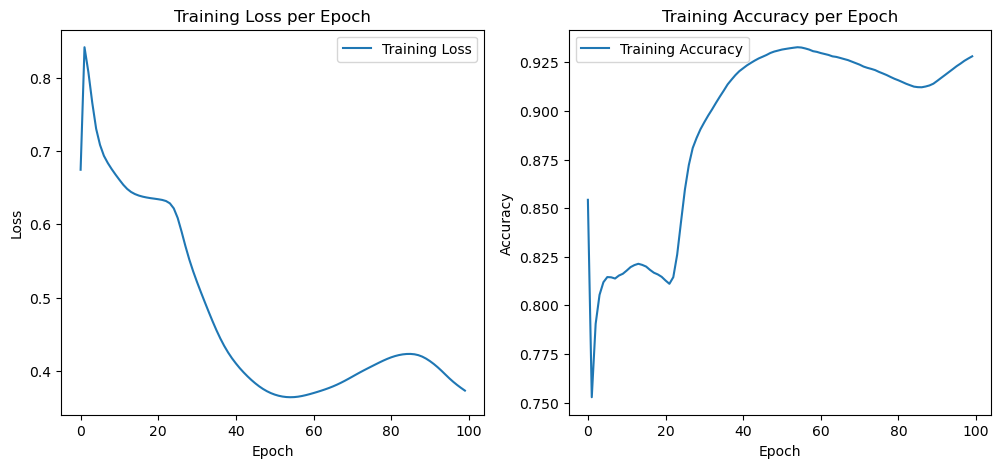

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracy curve
plt.subplot(1, 2, 2)
plt.plot(acc_list, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Unseen test set performance

In [17]:
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)

model.eval()
outputs = model(X_test_tensor)
with torch.no_grad():
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).float().cpu().numpy()

    # Calculate indicators
    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print("Accuracy: ", acc, ", Precision: ", precision, ", Recall: ", recall, ", F1: ", f1)

Accuracy:  0.8830585490694476 , Precision:  0.5420685770611843 , Recall:  0.9730788675429727 , F1:  0.6962695003391364


Save model

In [18]:
save_folder = "save_model"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"model_lstm_{current_time}.pt"
if multiplier == 1:
    model_filename = f"model_lstm_{current_time}_without_width_multiplier.pt"
full_path = os.path.join(save_folder, model_filename)
torch.save(model.state_dict(), full_path)

print("Model saved as:", full_path)

Model saved as: save_model/model_lstm_2023-11-22_22-07-05_without_width_multiplier.pt
